In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import xgboost as xgb
import pickle
import joblib
from sklearn.base import BaseEstimator, TransformerMixin
import warnings
warnings.filterwarnings('ignore')

from google.colab import drive
drive.mount('/content/drive')

df = pd.read_csv('/content/drive/MyDrive/geocoding_backup/hdb_geocoded_full.csv')

print(f"Dataset shape: {df.shape}")
df.head()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Dataset shape: (205699, 31)


,_id,month,town,flat_type,block,street_name,storey_range,floor_area_sqm,flat_model,lease_commence_date,...,period,latitude,longitude,geocoded_address,nearest_mrt_distance_km,nearest_mrt_name,nearest_mrt_line,near_mrt_500m,near_mrt_1km,distance_to_cbd_km
0,1,2017-01,ANG MO KIO,2 ROOM,406,ANG MO KIO AVE 10,10 TO 12,44.0,Improved,1979,...,2017-Q1,1.362005,103.853880,406 ANG MO KIO AVENUE 10 SINGAPORE 560406,1.008352,Ang Mo Kio,NS,0,0,8.653485
1,2,2017-01,ANG MO KIO,3 ROOM,108,ANG MO KIO AVE 4,01 TO 03,67.0,New Generation,1978,...,2017-Q1,1.370966,103.838202,108 ANG MO KIO AVENUE 4 KEBUN BARU HEIGHTS SIN...,1.271592,Ang Mo Kio,NS,0,0,9.772662
2,3,2017-01,ANG MO KIO,3 ROOM,602,ANG MO KIO AVE 5,01 TO 03,67.0,New Generation,1980,...,2017-Q1,1.380709,103.835368,602 ANG MO KIO AVENUE 5 YIO CHU KANG GREEN SIN...,1.980100,Ang Mo Kio,NS,0,0,10.893193
3,4,2017-01,ANG MO KIO,3 ROOM,465,ANG MO KIO AVE 10,04 TO 06,68.0,New Generation,1980,...,2017-Q1,1.366201,103.857201,465 ANG MO KIO AVENUE 10 TECK GHEE HORIZON SIN...,0.944659,Ang Mo Kio,NS,0,1,9.135032
4,5,2017-01,ANG MO KIO,3 ROOM,601,ANG MO KIO AVE 5,01 TO 03,67.0,New Generation,1980,...,2017-Q1,1.381041,103.835132,601 ANG MO KIO AVENUE 5 MY FIRST SKOOL SINGAPO...,2.023385,Ang Mo Kio,NS,0,0,10.934151


In [ ]:
ccr_towns = ['DOWNTOWN CORE', 'MARINA SOUTH', 'MARINA EAST', 'SOUTHERN ISLANDS',
             'MUSEUM', 'RIVER VALLEY', 'ORCHARD', 'NEWTON']

rcr_towns = ['BISHAN', 'TOA PAYOH', 'GEYLANG', 'KALLANG', 'MARINE PARADE',
             'QUEENSTOWN', 'BUKIT MERAH', 'CENTRAL AREA', 'BUKIT TIMAH', 'NOVENA']

def map_town_to_region(town):
    if town in ccr_towns:
        return 'CCR'
    elif town in rcr_towns:
        return 'RCR'
    else:
        return 'OCR'

df['region'] = df['town'].apply(map_town_to_region)

df['region_numeric'] = df['region'].map({'CCR': 0, 'RCR': 1, 'OCR': 2})

print("\nRegion distribution:")
print(df['region'].value_counts())
print("\nRegion numeric distribution:")
print(df['region_numeric'].value_counts())


Region distribution:
region
OCR    173624
RCR     32075
Name: count, dtype: int64

Region numeric distribution:
region_numeric
2    173624
1     32075
Name: count, dtype: int64


In [ ]:
if 'mature_estate' not in df.columns:
    mature_estates = ['ANG MO KIO', 'BEDOK', 'BISHAN', 'BUKIT MERAH', 'BUKIT TIMAH',
                      'CENTRAL AREA', 'CLEMENTI', 'GEYLANG', 'KALLANG/WHAMPOA', 'MARINE PARADE',
                      'PASIR RIS', 'QUEENSTOWN', 'SERANGOON', 'TAMPINES', 'TOA PAYOH']

    df['mature_estate'] = df['town'].apply(lambda x: 1 if x in mature_estates else 0)

print("\nMature estate distribution:")
print(df['mature_estate'].value_counts() if 'mature_estate' in df.columns else "Mature estate not created")


Mature estate distribution:
mature_estate
0    120017
1     85682
Name: count, dtype: int64


#PRepare for Feature Engineering

#Feature Engineering

In [ ]:
if 'remaining_lease_at_transaction' not in df.columns:
    def extract_remaining_lease(lease_str):
        try:
            parts = lease_str.split()
            years = int(parts[0])
            months = int(parts[2]) if len(parts) > 2 else 0
            return years + months/12
        except:
            return None

    df['remaining_lease_at_transaction'] = df['remaining_lease'].apply(extract_remaining_lease)

df['high_floor_mrt_proximity'] = ((df['storey_mid'] > df['storey_mid'].median()) &
                                 (df['nearest_mrt_distance_km'] < df['nearest_mrt_distance_km'].median())).astype(int)

df['area_cbd_interaction'] = df['floor_area_sqm'] * (1 / (df['distance_to_cbd_km'] + 1))

df['region_lease_interaction'] = df['region_numeric'] * df['remaining_lease_at_transaction']

df['floor_mrt_premium'] = df['storey_mid'] * (1 / (df['nearest_mrt_distance_km'] + 1))

numeric_features = ['floor_area_sqm', 'storey_mid', 'remaining_lease_at_transaction',
                   'nearest_mrt_distance_km', 'distance_to_cbd_km']

for feature in numeric_features:
    if feature in df.columns:  # Check if feature exists
        df[f'{feature}_norm'] = (df[feature] - df[feature].min()) / (df[feature].max() - df[feature].min())

df['area_premium_for_flattype'] = df.groupby('flat_type')['floor_area_sqm'].transform(lambda x: (x - x.mean()) / x.std())

if 'town_avg_price' not in df.columns:
    town_avg_price = df.groupby('town')['resale_price'].mean().reset_index()
    town_avg_price.columns = ['town', 'town_avg_price']
    df = pd.merge(df, town_avg_price, on='town', how='left')

    town_avg_price_per_sqm = df.groupby('town')['price_per_sqm'].mean().reset_index()
    town_avg_price_per_sqm.columns = ['town', 'town_avg_price_per_sqm']
    df = pd.merge(df, town_avg_price_per_sqm, on='town', how='left')

In [ ]:
if 'remaining_lease_at_transaction' not in df.columns:
    def extract_remaining_lease(lease_str):
        try:
            parts = lease_str.split()
            years = int(parts[0])
            months = int(parts[2]) if len(parts) > 2 else 0
            return years + months/12
        except:
            return None

    df['remaining_lease_at_transaction'] = df['remaining_lease'].apply(extract_remaining_lease)

df['high_floor_mrt_proximity'] = ((df['storey_mid'] > df['storey_mid'].median()) &
                                 (df['nearest_mrt_distance_km'] < df['nearest_mrt_distance_km'].median())).astype(int)

df['area_cbd_interaction'] = df['floor_area_sqm'] * (1 / (df['distance_to_cbd_km'] + 1))

df['region_lease_interaction'] = df['region_numeric'] * df['remaining_lease_at_transaction']

df['floor_mrt_premium'] = df['storey_mid'] * (1 / (df['nearest_mrt_distance_km'] + 1))

numeric_features = ['floor_area_sqm', 'storey_mid', 'remaining_lease_at_transaction',
                   'nearest_mrt_distance_km', 'distance_to_cbd_km']

for feature in numeric_features:
    if feature in df.columns:
        df[f'{feature}_norm'] = (df[feature] - df[feature].min()) / (df[feature].max() - df[feature].min())

df['area_premium_for_flattype'] = df.groupby('flat_type')['floor_area_sqm'].transform(lambda x: (x - x.mean()) / x.std())

if 'town_avg_price' not in df.columns:
    town_avg_price = df.groupby('town')['resale_price'].mean().reset_index()
    town_avg_price.columns = ['town', 'town_avg_price']
    df = pd.merge(df, town_avg_price, on='town', how='left')

    town_avg_price_per_sqm = df.groupby('town')['price_per_sqm'].mean().reset_index()
    town_avg_price_per_sqm.columns = ['town', 'town_avg_price_per_sqm']
    df = pd.merge(df, town_avg_price_per_sqm, on='town', how='left')

In [ ]:
if 'location_score' not in df.columns:
    df['mrt_proximity_score'] = 1 / (df['nearest_mrt_distance_km'] + 0.1)
    df['cbd_proximity_score'] = 1 / (df['distance_to_cbd_km'] + 0.1)

    df['mrt_proximity_score'] = (df['mrt_proximity_score'] - df['mrt_proximity_score'].min()) / (df['mrt_proximity_score'].max() - df['mrt_proximity_score'].min())
    df['cbd_proximity_score'] = (df['cbd_proximity_score'] - df['cbd_proximity_score'].min()) / (df['cbd_proximity_score'].max() - df['cbd_proximity_score'].min())

    df['location_score'] = 0.5 * df['mrt_proximity_score'] + 0.3 * df['cbd_proximity_score'] + 0.2 * df['region_numeric'].map({0: 1, 1: 0.66, 2: 0.33})

if 'property_quality_score' not in df.columns:
    df['lease_score'] = df['remaining_lease_at_transaction'] / 99  # Normalize by max lease
    df['floor_score'] = df['storey_mid'] / df['storey_mid'].max()

    df['property_quality_score'] = 0.4 * df['lease_score'] + 0.3 * df['floor_score'] + 0.3 * df['area_premium_for_flattype']

engineered_features = ['region_numeric', 'remaining_lease_at_transaction', 'high_floor_mrt_proximity',
                      'area_cbd_interaction', 'region_lease_interaction', 'floor_mrt_premium',
                      'area_premium_for_flattype', 'location_score', 'property_quality_score']

print("\nNaN counts in engineered features:")
for feature in engineered_features:
    if feature in df.columns:
        print(f"{feature}: {df[feature].isna().sum()}")

for feature in engineered_features:
    if feature in df.columns and df[feature].isna().sum() > 0:
        if feature in ['region_numeric', 'high_floor_mrt_proximity']:
            # For categorical/binary features
            df[feature] = df[feature].fillna(df[feature].mode()[0])
        else:
            # For numeric features
            df[feature] = df[feature].fillna(df[feature].median())

df.to_csv('/content/drive/MyDrive/geocoding_backup/hdb_fully_engineered_new.csv', index=False)
print("\nEngineered dataset saved successfully")

print("\nNew features created:")
for feature in engineered_features:
    if feature in df.columns:
        print(feature)

print("\nSample of engineered data:")
df[engineered_features + ['resale_price']].head()


NaN counts in engineered features:
region_numeric: 0
remaining_lease_at_transaction: 0
high_floor_mrt_proximity: 0
area_cbd_interaction: 0
region_lease_interaction: 0
floor_mrt_premium: 0
area_premium_for_flattype: 77
location_score: 0
property_quality_score: 77

Engineered dataset saved successfully

New features created:
region_numeric
remaining_lease_at_transaction
high_floor_mrt_proximity
area_cbd_interaction
region_lease_interaction
floor_mrt_premium
area_premium_for_flattype
location_score
property_quality_score

Sample of engineered data:


,region_numeric,remaining_lease_at_transaction,high_floor_mrt_proximity,area_cbd_interaction,region_lease_interaction,floor_mrt_premium,area_premium_for_flattype,location_score,property_quality_score,resale_price
0,2,61.333333,1,4.557939,122.666667,5.477127,-0.512137,0.142403,0.160170,232000.0
1,2,60.583333,0,6.219447,121.166667,0.880440,-0.178774,0.125392,0.203149,250000.0
2,2,62.416667,0,5.633474,124.833333,0.671119,-0.178774,0.102966,0.210556,262000.0
3,2,62.083333,0,6.709402,124.166667,2.571145,-0.023087,0.145402,0.273916,265000.0
4,2,62.416667,0,5.614141,124.833333,0.661510,-0.178774,0.102097,0.210556,265000.0


#Data Cleansing , FIlling NAs


Remaining NaN counts after filling:
region_numeric: 0
remaining_lease_at_transaction: 0
high_floor_mrt_proximity: 0
area_cbd_interaction: 0
region_lease_interaction: 0
floor_mrt_premium: 0
area_premium_for_flattype: 0
location_score: 0
property_quality_score: 0


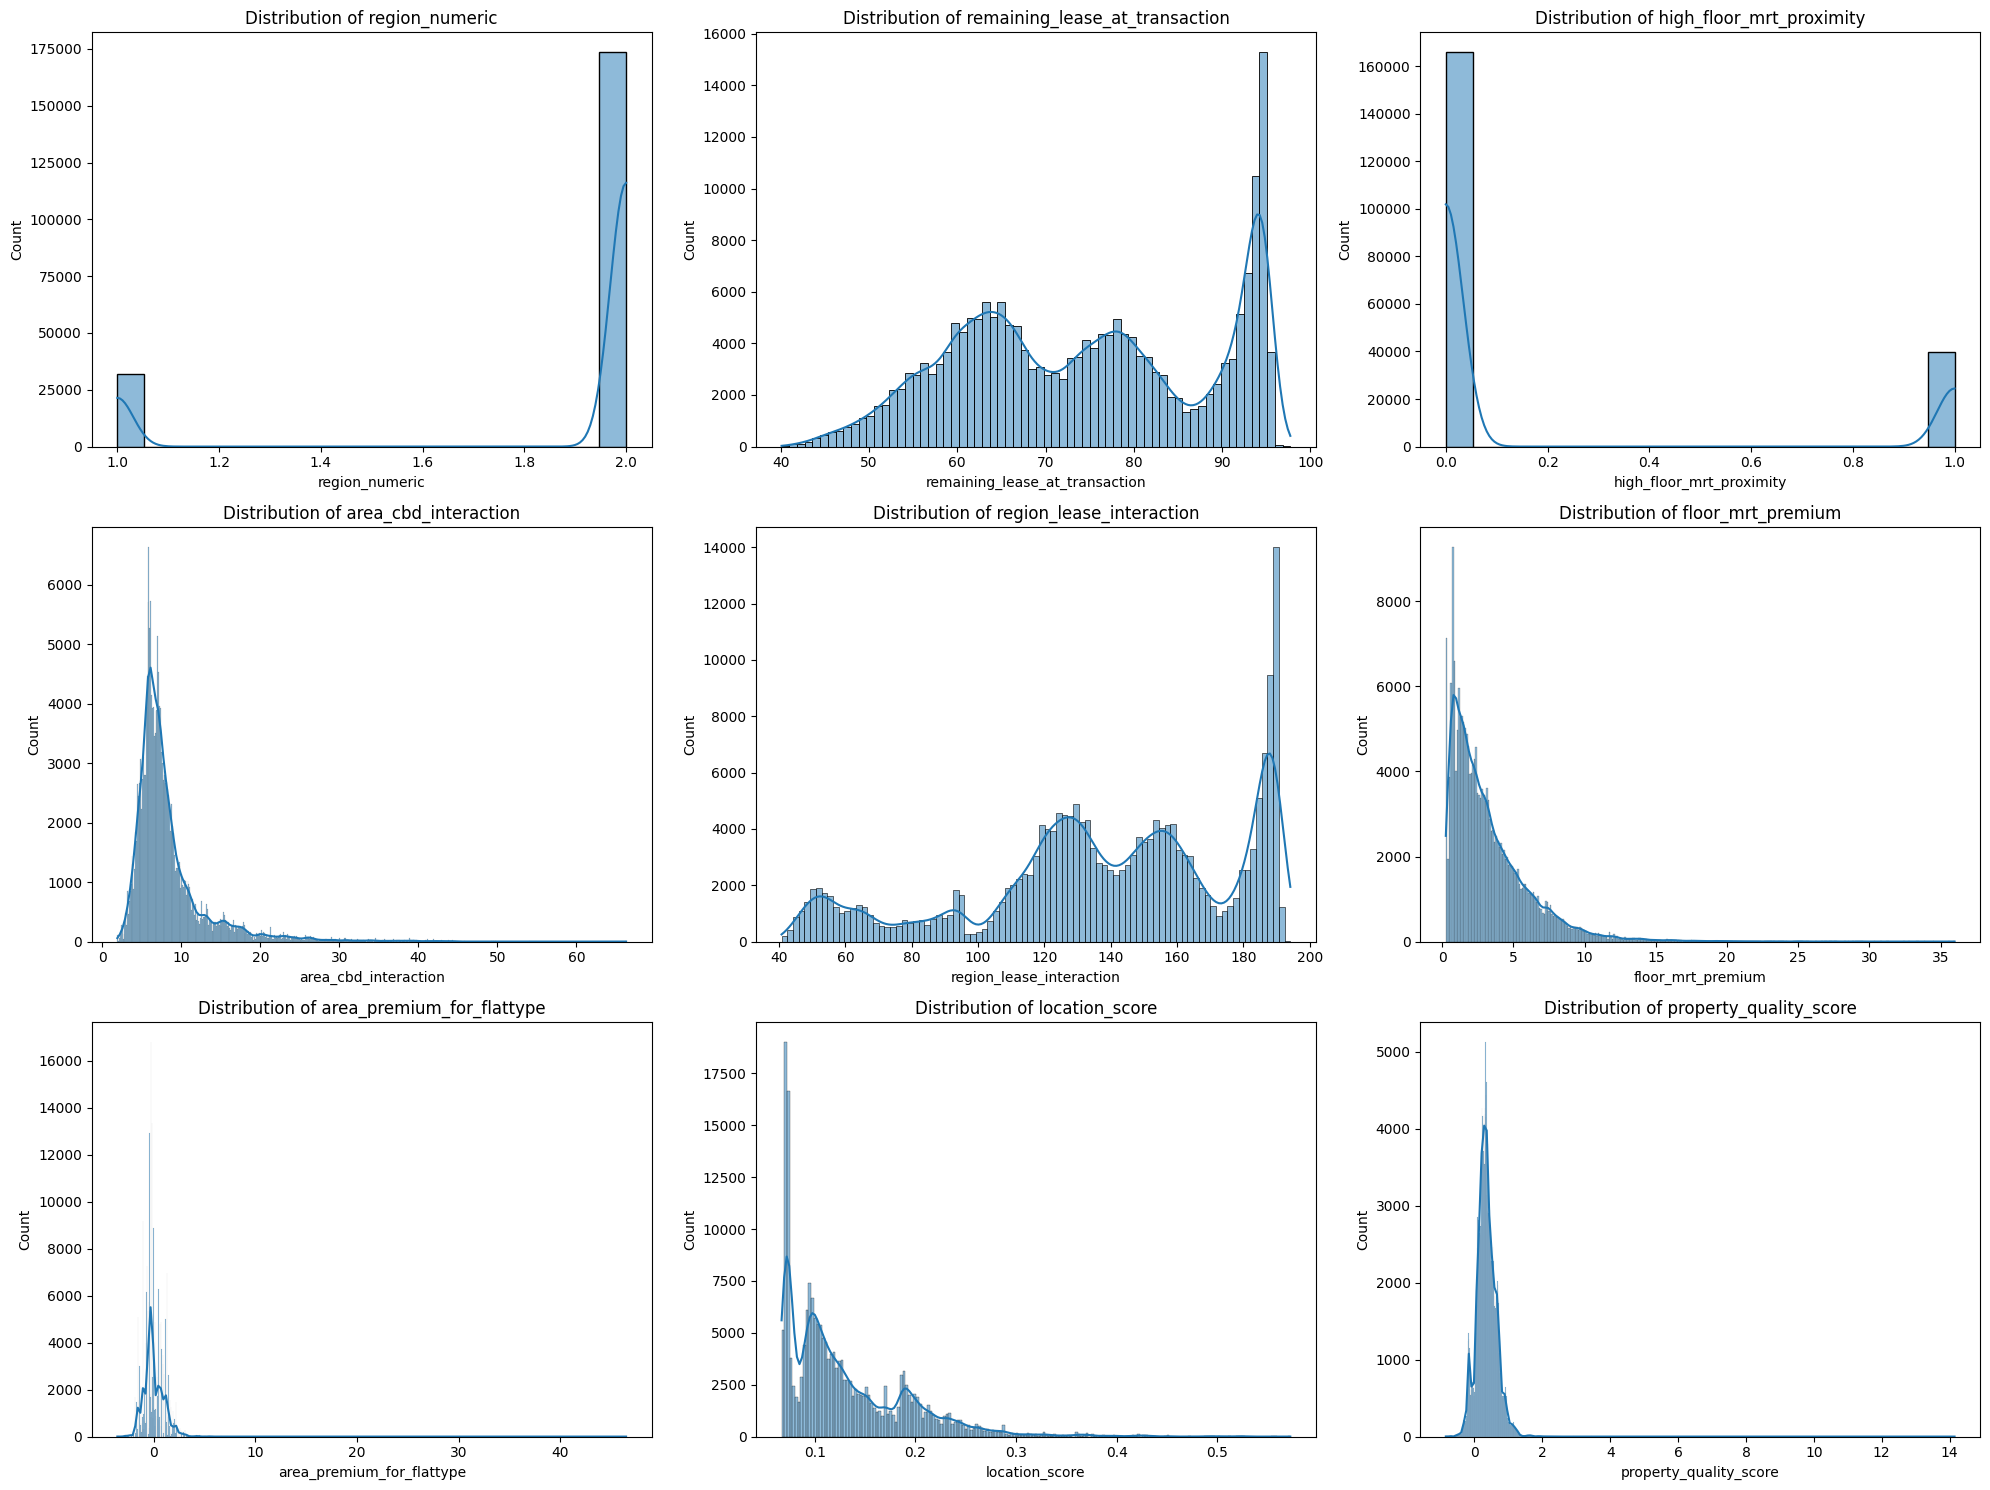

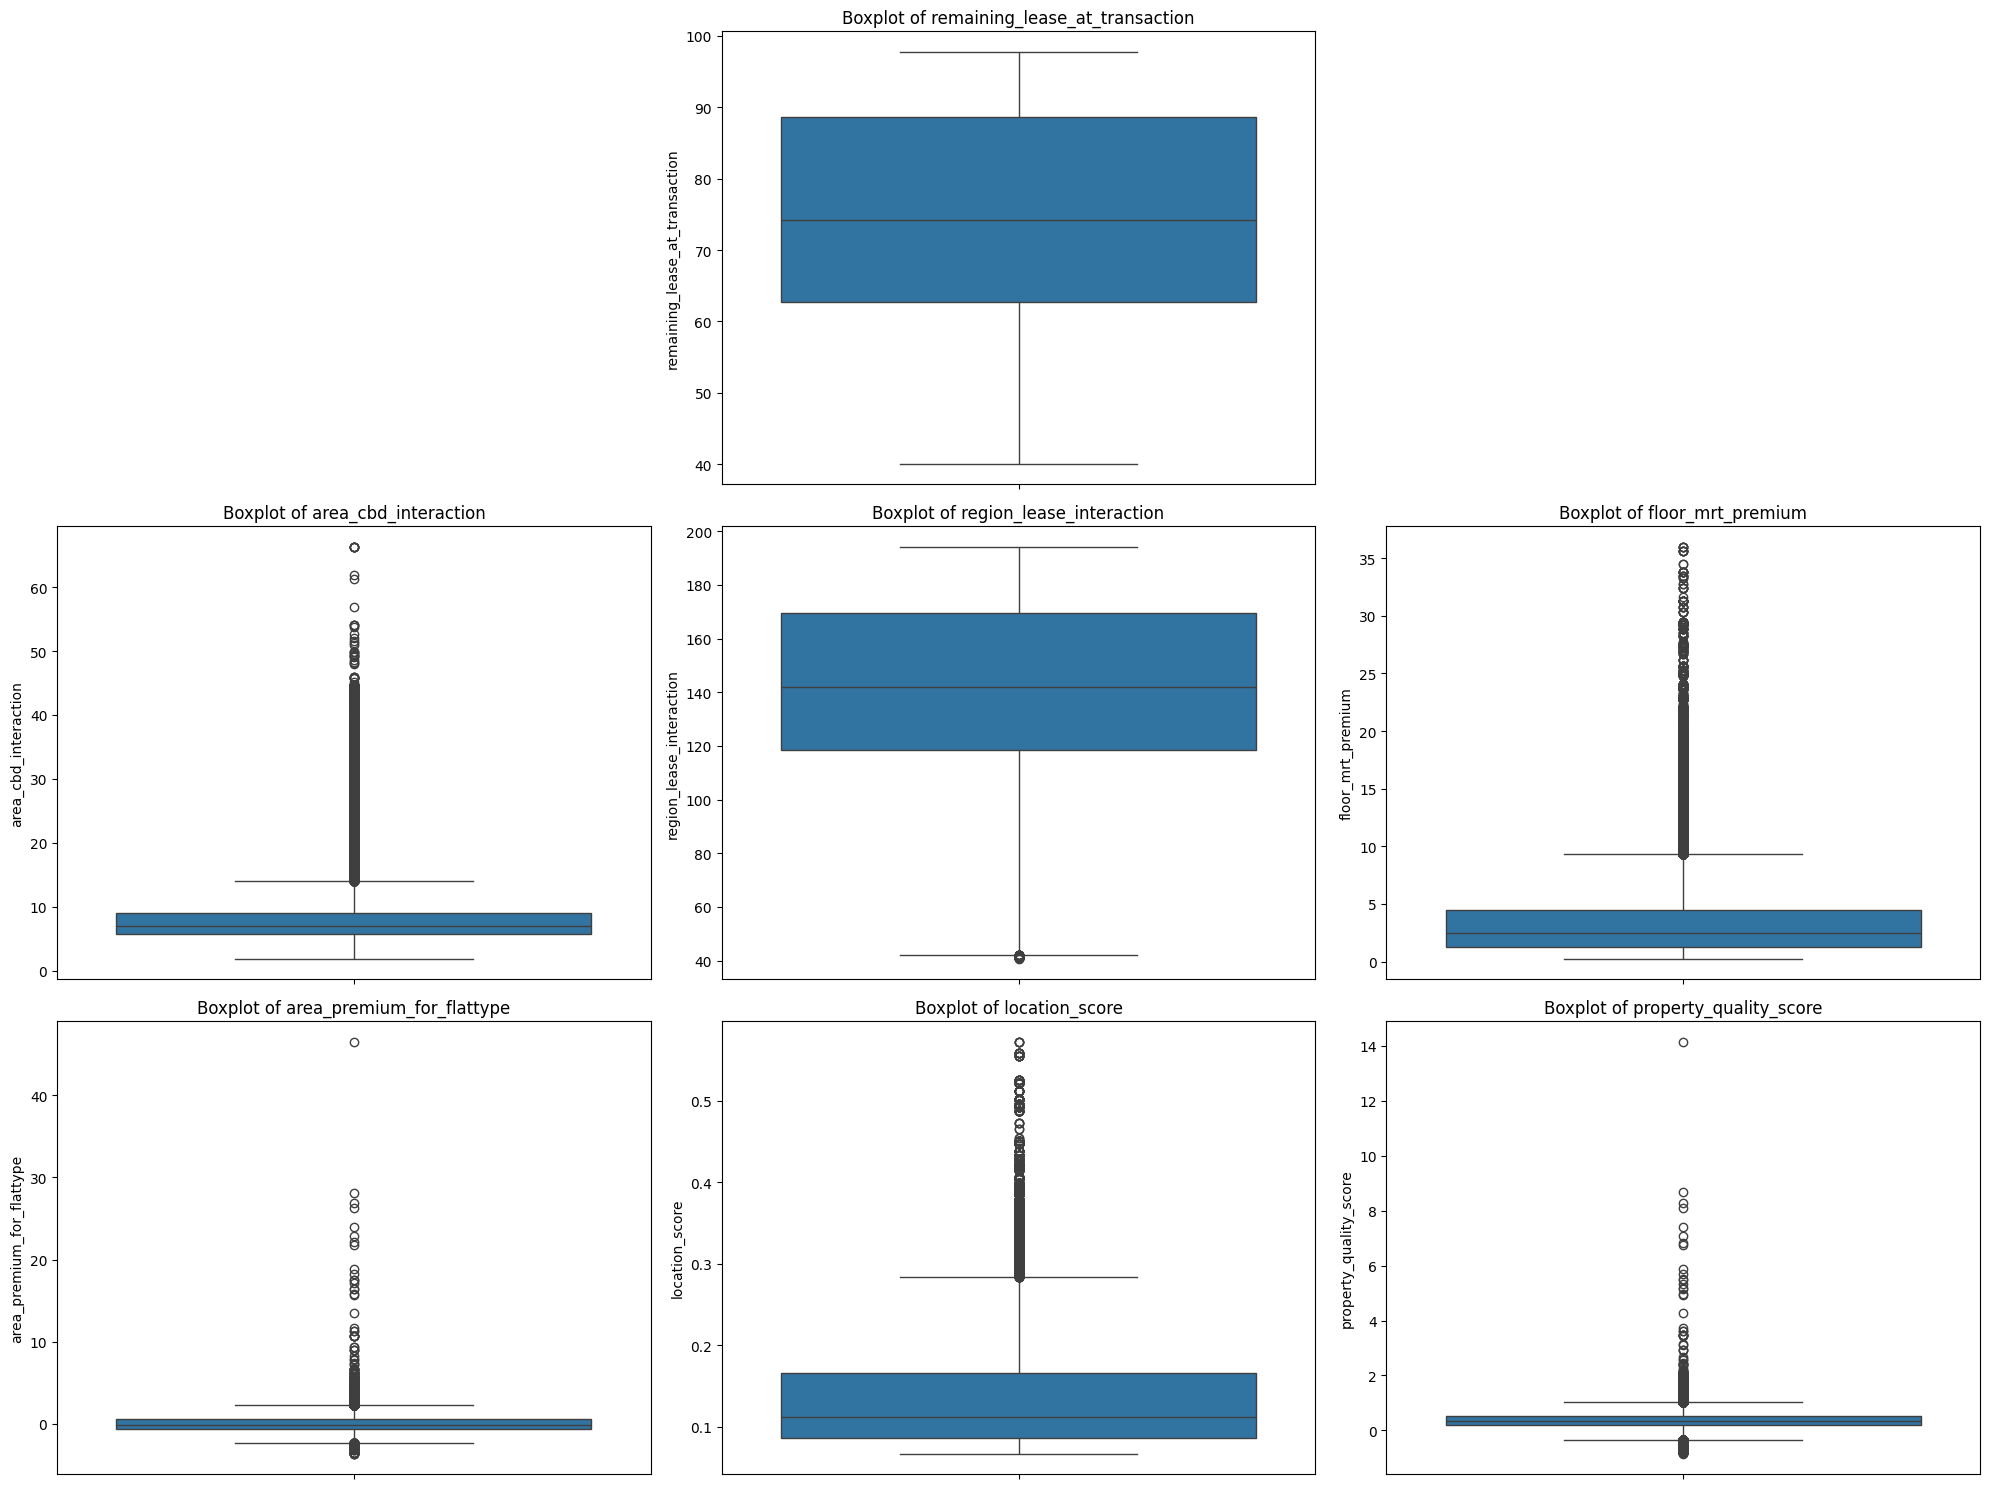


Correlations with resale_price:
area_cbd_interaction: 0.5165
floor_mrt_premium: 0.3513
remaining_lease_at_transaction: 0.3119
location_score: 0.2195
region_numeric: -0.2041
high_floor_mrt_proximity: 0.1873
property_quality_score: 0.1405
area_premium_for_flattype: 0.0370
region_lease_interaction: 0.0344


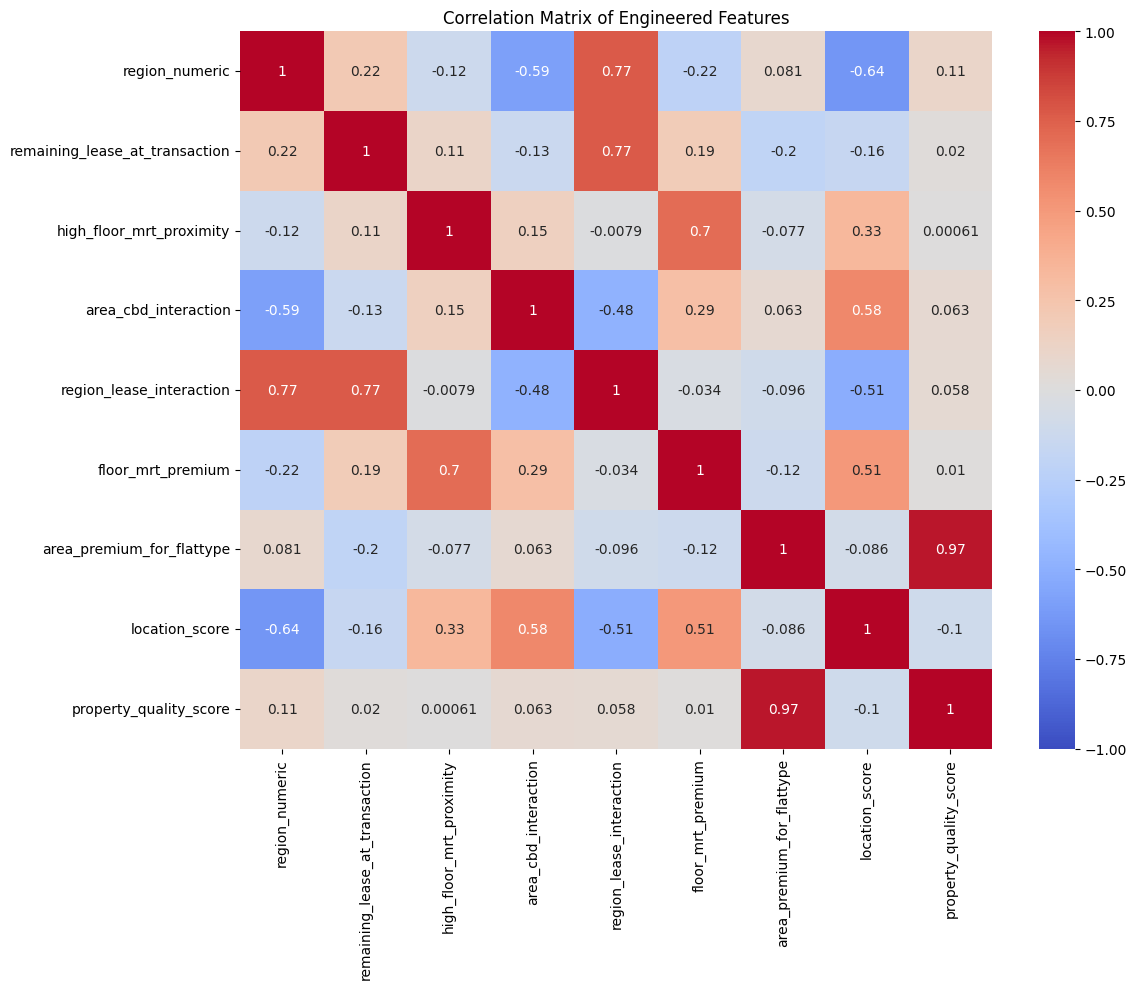

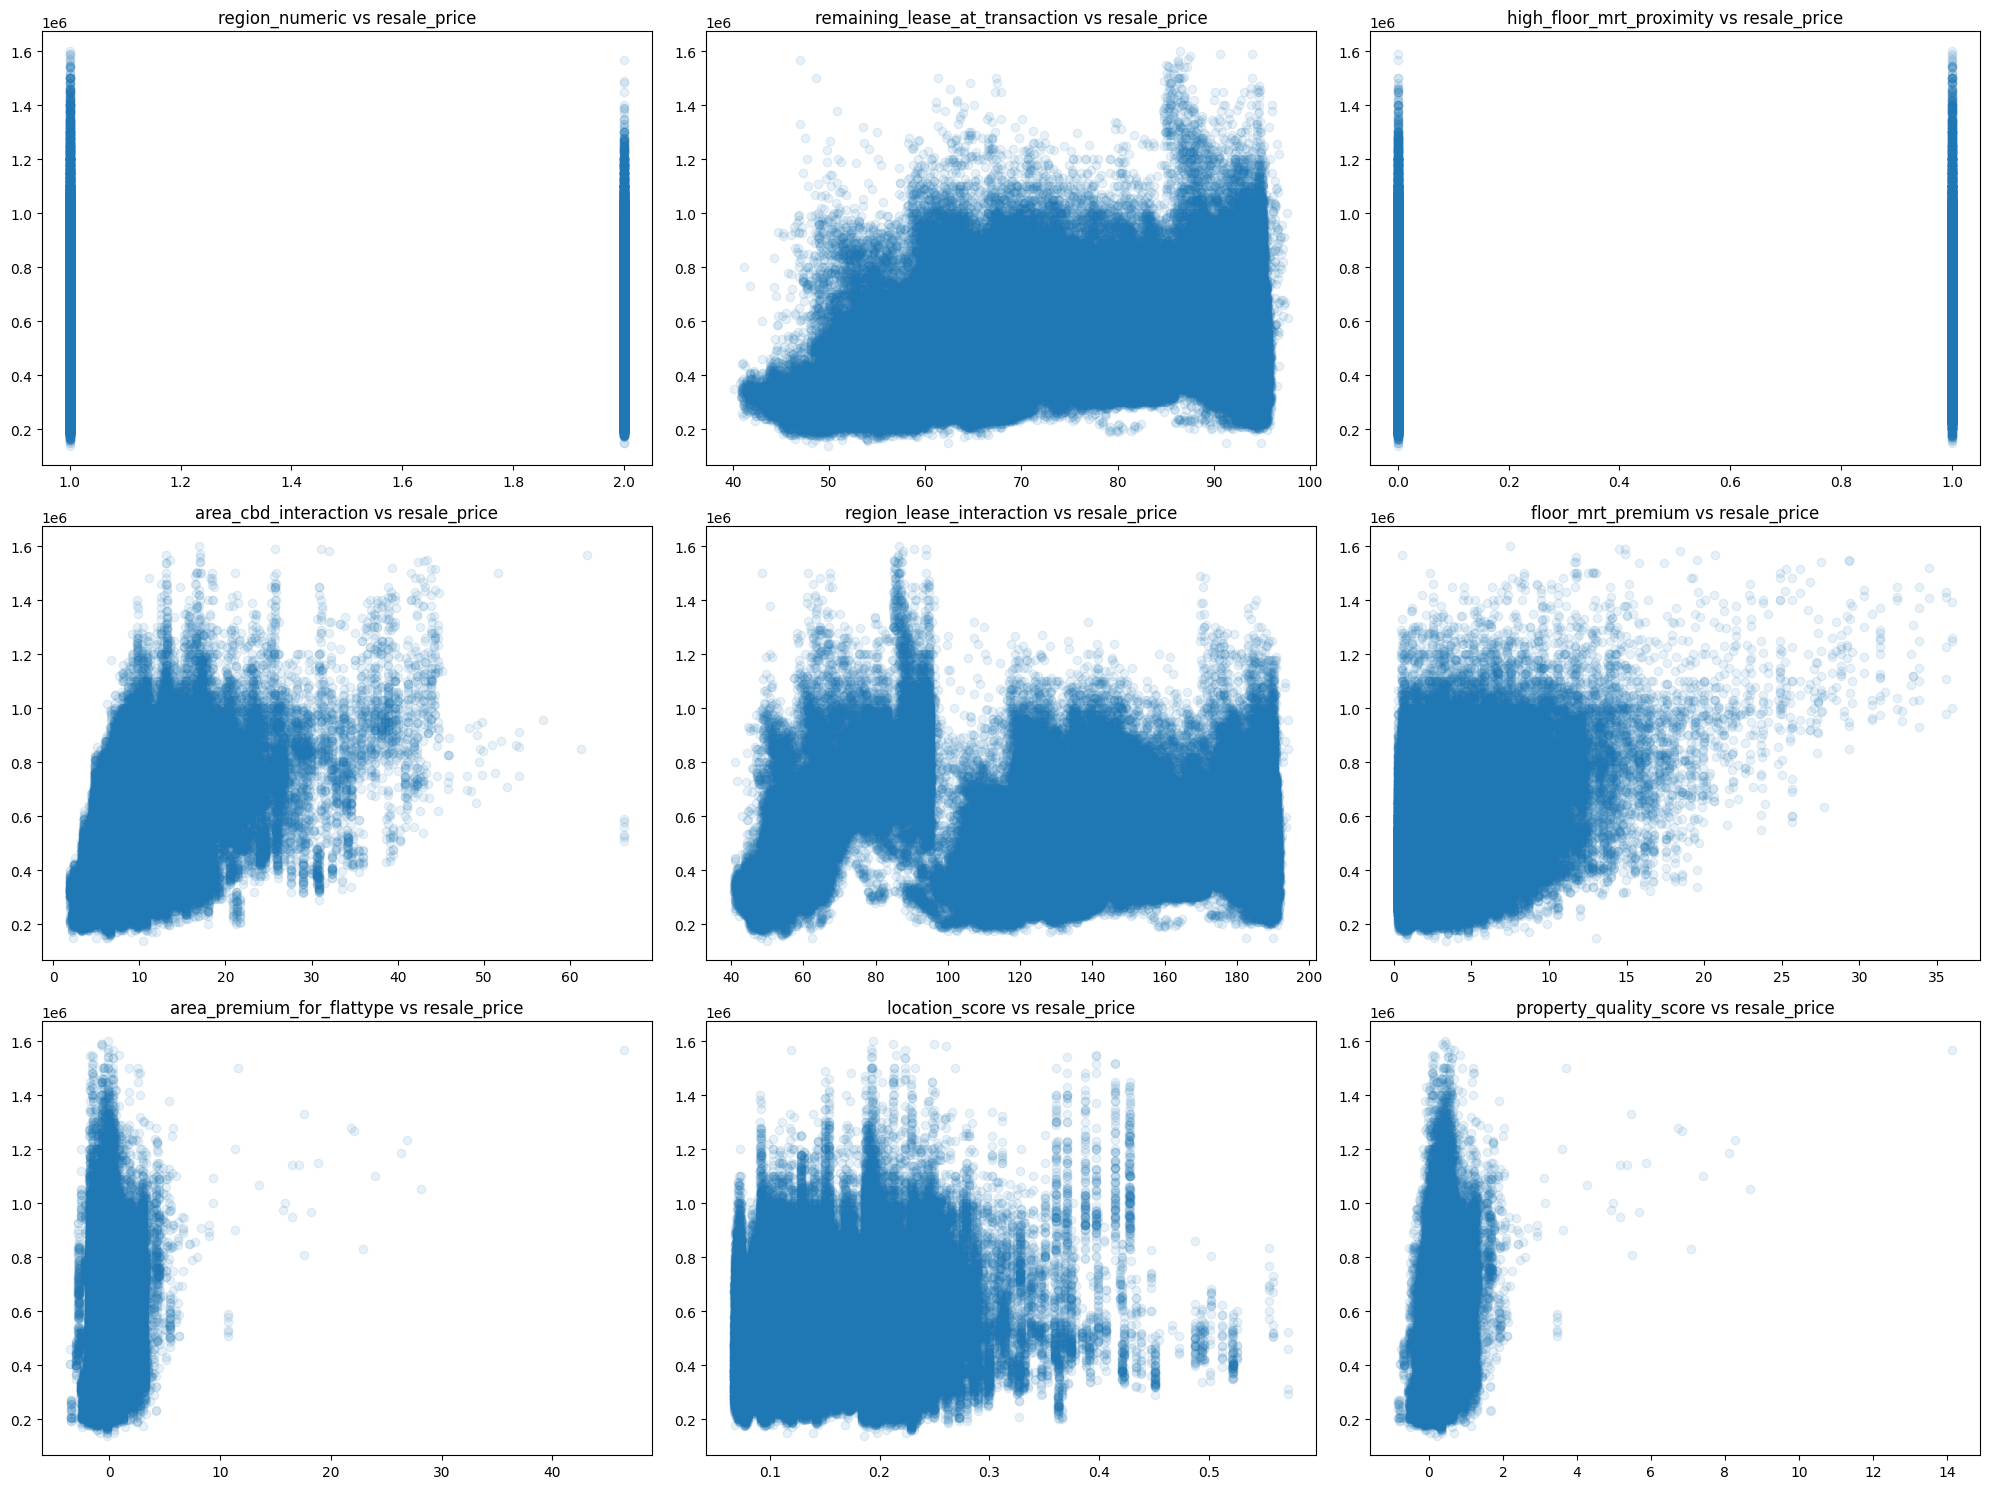

In [ ]:
df['area_premium_for_flattype'] = df['area_premium_for_flattype'].fillna(0)
df['property_quality_score'] = df['property_quality_score'].fillna(df['property_quality_score'].median())

print("\nRemaining NaN counts after filling:")
for feature in engineered_features:
    if feature in df.columns:
        print(f"{feature}: {df[feature].isna().sum()}")

import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(20, 15))
for i, feature in enumerate(engineered_features):
    if feature in df.columns:
        plt.subplot(3, 3, i+1)
        sns.histplot(df[feature], kde=True)
        plt.title(f'Distribution of {feature}')
        plt.tight_layout()
plt.show()

plt.figure(figsize=(20, 15))
for i, feature in enumerate(engineered_features):
    if feature in df.columns and feature not in ['region_numeric', 'high_floor_mrt_proximity']:
        plt.subplot(3, 3, i+1)
        sns.boxplot(y=df[feature])
        plt.title(f'Boxplot of {feature}')
        plt.tight_layout()
plt.show()

correlations = []
for feature in engineered_features:
    if feature in df.columns:
        correlation = df[feature].corr(df['resale_price'])
        correlations.append((feature, correlation))

correlations.sort(key=lambda x: abs(x[1]), reverse=True)
print("\nCorrelations with resale_price:")
for feature, correlation in correlations:
    print(f"{feature}: {correlation:.4f}")

correlation_matrix = df[engineered_features].corr()
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Matrix of Engineered Features')
plt.tight_layout()
plt.show()

plt.figure(figsize=(20, 15))
for i, feature in enumerate(engineered_features):
    if feature in df.columns and i < 9:  # Limiting to 9 subplots
        plt.subplot(3, 3, i+1)
        plt.scatter(df[feature], df['resale_price'], alpha=0.1)
        plt.title(f'{feature} vs resale_price')
        plt.tight_layout()
plt.show()

#Some additional checks

In [ ]:

print("\nSpot checks for extreme values:")
for feature in engineered_features:
    if feature in df.columns and feature not in ['region_numeric', 'high_floor_mrt_proximity']:
        min_idx = df[feature].idxmin()
        max_idx = df[feature].idxmax()

        print(f"\nFeature: {feature}")
        print(f"Min value: {df.loc[min_idx, feature]:.4f} at index {min_idx}")
        print(f"Corresponding resale_price: ${df.loc[min_idx, 'resale_price']:,.2f}")
        print(f"Max value: {df.loc[max_idx, feature]:.4f} at index {max_idx}")
        print(f"Corresponding resale_price: ${df.loc[max_idx, 'resale_price']:,.2f}")

print("\nLogical consistency checks:")
high_loc_score = df[df['location_score'] > df['location_score'].quantile(0.9)]['resale_price'].mean()
low_loc_score = df[df['location_score'] < df['location_score'].quantile(0.1)]['resale_price'].mean()
print(f"Average price for top 10% location_score: ${high_loc_score:,.2f}")
print(f"Average price for bottom 10% location_score: ${low_loc_score:,.2f}")
print(f"Ratio: {high_loc_score/low_loc_score:.2f}x")

high_quality = df[df['property_quality_score'] > df['property_quality_score'].quantile(0.9)]['resale_price'].mean()
low_quality = df[df['property_quality_score'] < df['property_quality_score'].quantile(0.1)]['resale_price'].mean()
print(f"Average price for top 10% property_quality_score: ${high_quality:,.2f}")
print(f"Average price for bottom 10% property_quality_score: ${low_quality:,.2f}")
print(f"Ratio: {high_quality/low_quality:.2f}x")

long_lease = df[df['remaining_lease_at_transaction'] > df['remaining_lease_at_transaction'].quantile(0.9)]['resale_price'].mean()
short_lease = df[df['remaining_lease_at_transaction'] < df['remaining_lease_at_transaction'].quantile(0.1)]['resale_price'].mean()
print(f"Average price for top 10% remaining_lease: ${long_lease:,.2f}")
print(f"Average price for bottom 10% remaining_lease: ${short_lease:,.2f}")
print(f"Ratio: {long_lease/short_lease:.2f}x")

region_prices = df.groupby('region_numeric')['resale_price'].mean()
print("\nAverage prices by region:")
for region, price in region_prices.items():
    region_name = {0: 'CCR', 1: 'RCR', 2: 'OCR'}[region]
    print(f"Region {region_name}: ${price:,.2f}")

print("\nAverage prices for high_floor_mrt_proximity:")
print(f"Yes (1): ${df[df['high_floor_mrt_proximity'] == 1]['resale_price'].mean():,.2f}")
print(f"No (0): ${df[df['high_floor_mrt_proximity'] == 0]['resale_price'].mean():,.2f}")

df.to_csv('/content/drive/MyDrive/geocoding_backup/hdb_fully_engineered_cleaned.csv', index=False)
print("\nCleaned engineered dataset saved successfully")


Spot checks for extreme values:

Feature: remaining_lease_at_transaction
Min value: 40.0833 at index 197850
Corresponding resale_price: $350,000.00
Max value: 97.7500 at index 74354
Corresponding resale_price: $612,000.00

Feature: area_cbd_interaction
Min value: 1.9115 at index 175375
Corresponding resale_price: $360,000.00
Max value: 66.2846 at index 22971
Corresponding resale_price: $560,000.00

Feature: region_lease_interaction
Min value: 40.7500 at index 204682
Corresponding resale_price: $372,888.00
Max value: 194.1667 at index 73752
Corresponding resale_price: $957,888.00

Feature: floor_mrt_premium
Min value: 0.2566 at index 65700
Corresponding resale_price: $416,000.00
Max value: 35.9830 at index 27137
Corresponding resale_price: $999,000.00

Feature: area_premium_for_flattype
Min value: -3.5963 at index 23449
Corresponding resale_price: $405,000.00
Max value: 46.4806 at index 186422
Corresponding resale_price: $1,568,000.00

Feature: location_score
Min value: 0.0671 at index

#Adjustments and feature refinements

In [ ]:
df['composite_quality_area'] = (df['area_premium_for_flattype'] + df['property_quality_score']) / 2

from sklearn.preprocessing import RobustScaler

scaler = RobustScaler()
df['property_quality_score_scaled'] = scaler.fit_transform(df[['property_quality_score']])
df['area_cbd_interaction_scaled'] = scaler.fit_transform(df[['area_cbd_interaction']])
df['floor_mrt_premium_scaled'] = scaler.fit_transform(df[['floor_mrt_premium']])

from sklearn.ensemble import RandomForestRegressor

test_features = [
    'region_numeric', 'remaining_lease_at_transaction', 'high_floor_mrt_proximity',
    'area_cbd_interaction_scaled', 'region_lease_interaction', 'floor_mrt_premium_scaled',
    'area_premium_for_flattype', 'location_score', 'property_quality_score_scaled',
    'composite_quality_area'
]

sample_indices = np.random.choice(df.index, size=int(len(df)*0.2), replace=False)
df_sample = df.loc[sample_indices]

X_sample = df_sample[test_features]
y_sample = df_sample['resale_price']

X_sample = X_sample.fillna(X_sample.median())

rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_sample, y_sample)

feature_importance = pd.DataFrame({
    'Feature': test_features,
    'Importance': rf.feature_importances_
}).sort_values('Importance', ascending=False)

print("\nFeature Importance from Random Forest:")
print(feature_importance)

basic_features = [
    'region_numeric', 'remaining_lease_at_transaction', 'high_floor_mrt_proximity',
    'area_cbd_interaction_scaled', 'floor_mrt_premium_scaled', 'location_score'
]

extended_features = basic_features + ['region_lease_interaction']

alternative_features = basic_features + ['composite_quality_area']

df.to_csv('/content/drive/MyDrive/geocoding_backup/hdb_fully_engineered_refined.csv', index=False)
print("\nRefined engineered dataset saved successfully")


Feature Importance from Random Forest:
                          Feature  Importance
3     area_cbd_interaction_scaled    0.373628
1  remaining_lease_at_transaction    0.271410
7                  location_score    0.080846
6       area_premium_for_flattype    0.061274
4        region_lease_interaction    0.060992
5        floor_mrt_premium_scaled    0.052980
8   property_quality_score_scaled    0.051268
9          composite_quality_area    0.044760
2        high_floor_mrt_proximity    0.001553
0                  region_numeric    0.001289

Refined engineered dataset saved successfully


#Define feature sets and Split

In [ ]:
optimized_features = [
    'area_cbd_interaction_scaled',
    'remaining_lease_at_transaction',
    'location_score',
    'area_premium_for_flattype',
    'region_lease_interaction',
    'floor_mrt_premium_scaled',
    'property_quality_score_scaled'
]

alternative_features = [
    'area_cbd_interaction_scaled',
    'remaining_lease_at_transaction',
    'location_score',
    'area_premium_for_flattype',
    'floor_mrt_premium_scaled'
]

full_features = [
    'area_cbd_interaction_scaled',
    'remaining_lease_at_transaction',
    'location_score',
    'area_premium_for_flattype',
    'region_lease_interaction',
    'floor_mrt_premium_scaled',
    'property_quality_score_scaled',
    'composite_quality_area',
    'high_floor_mrt_proximity',
    'region_numeric'
]

categorical_features = ['town', 'flat_type', 'flat_model']

optimized_features_complete = categorical_features + optimized_features
alternative_features_complete = categorical_features + alternative_features
full_features_complete = categorical_features + full_features

X_optimized = df[optimized_features_complete]
X_alternative = df[alternative_features_complete]
X_full = df[full_features_complete]
y = df['resale_price']

from sklearn.model_selection import train_test_split

X_train_opt, X_test_opt, y_train, y_test = train_test_split(X_optimized, y, test_size=0.2, random_state=42)
X_train_alt, X_test_alt, _, _ = train_test_split(X_alternative, y, test_size=0.2, random_state=42)
X_train_full, X_test_full, _, _ = train_test_split(X_full, y, test_size=0.2, random_state=42)



#Modeling

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder, RobustScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import xgboost as xgb
import pickle
import time
import warnings
warnings.filterwarnings('ignore')

df = pd.read_csv('/content/drive/MyDrive/geocoding_backup/hdb_fully_engineered_refined.csv')

print(f"Dataset loaded with shape: {df.shape}")

optimized_features = [
    'area_cbd_interaction_scaled',
    'remaining_lease_at_transaction',
    'location_score',
    'area_premium_for_flattype',
    'region_lease_interaction',
    'floor_mrt_premium_scaled',
    'property_quality_score_scaled'
]

alternative_features = [
    'area_cbd_interaction_scaled',
    'remaining_lease_at_transaction',
    'location_score',
    'area_premium_for_flattype',
    'floor_mrt_premium_scaled'
]

full_features = [
    'area_cbd_interaction_scaled',
    'remaining_lease_at_transaction',
    'location_score',
    'area_premium_for_flattype',
    'region_lease_interaction',
    'floor_mrt_premium_scaled',
    'property_quality_score_scaled',
    'composite_quality_area',
    'high_floor_mrt_proximity',
    'region_numeric'
]

categorical_features = ['town', 'flat_type', 'flat_model']

optimized_features_complete = categorical_features + optimized_features
alternative_features_complete = categorical_features + alternative_features
full_features_complete = categorical_features + full_features

target = 'resale_price'

X_optimized = df[optimized_features_complete]
X_alternative = df[alternative_features_complete]
X_full = df[full_features_complete]
y = df[target]

print("\nMissing values in optimized feature set:")
print(X_optimized.isnull().sum().sum())
print("\nMissing values in alternative feature set:")
print(X_alternative.isnull().sum().sum())
print("\nMissing values in full feature set:")
print(X_full.isnull().sum().sum())

for X in [X_optimized, X_alternative, X_full]:
    for col in categorical_features:
        if X[col].isnull().sum() > 0:
            X[col] = X[col].fillna(X[col].mode()[0])

    numeric_cols = [col for col in X.columns if col not in categorical_features]
    for col in numeric_cols:
        if X[col].isnull().sum() > 0:
            X[col] = X[col].fillna(X[col].median())

print("\nAfter filling, all feature sets have zero missing values")

X_train_opt, X_test_opt, y_train, y_test = train_test_split(X_optimized, y, test_size=0.2, random_state=42)
X_train_alt, X_test_alt, _, _ = train_test_split(X_alternative, y, test_size=0.2, random_state=42)
X_train_full, X_test_full, _, _ = train_test_split(X_full, y, test_size=0.2, random_state=42)

print(f"\nTraining set shape (optimized features): {X_train_opt.shape}")
print(f"Testing set shape (optimized features): {X_test_opt.shape}")

def create_preprocessor(X, categorical_features):
    numeric_features = [col for col in X.columns if col not in categorical_features]

    categorical_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('onehot', OneHotEncoder(handle_unknown='ignore'))
    ])

    numeric_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', StandardScaler())
    ])

    preprocessor = ColumnTransformer(
        transformers=[
            ('cat', categorical_transformer, categorical_features),
            ('num', numeric_transformer, numeric_features)
        ],
        remainder='drop'
    )

    return preprocessor

preprocessor_opt = create_preprocessor(X_optimized, categorical_features)
preprocessor_alt = create_preprocessor(X_alternative, categorical_features)
preprocessor_full = create_preprocessor(X_full, categorical_features)

use_gpu = True  # Set to False if no use GPU

models = {
    'random_forest': RandomForestRegressor(
        n_estimators=100,
        n_jobs=-1,
        random_state=42
    ),
    'gradient_boosting': GradientBoostingRegressor(
        n_estimators=100,
        random_state=42
    ),
    'xgboost': xgb.XGBRegressor(
        n_estimators=100,
        tree_method='gpu_hist' if use_gpu else 'hist',
        random_state=42
    )
}

pipelines = {}
for feature_set in ['optimized', 'alternative', 'full']:
    for model_name, model in models.items():
        if feature_set == 'optimized':
            preprocessor = preprocessor_opt
            X_train = X_train_opt
            X_test = X_test_opt
        elif feature_set == 'alternative':
            preprocessor = preprocessor_alt
            X_train = X_train_alt
            X_test = X_test_alt
        else:  # full
            preprocessor = preprocessor_full
            X_train = X_train_full
            X_test = X_test_full

        pipeline = Pipeline(steps=[
            ('preprocessor', preprocessor),
            ('model', model)
        ])

        pipeline_name = f"{model_name}_{feature_set}"
        pipelines[pipeline_name] = (pipeline, X_train, X_test)

print(f"\nCreated {len(pipelines)} model pipelines")

results = {}

for pipeline_name, (pipeline, X_train, X_test) in pipelines.items():
    print(f"\nTraining {pipeline_name}...")
    start_time = time.time()

    pipeline.fit(X_train, y_train)
    training_time = time.time() - start_time

    y_pred = pipeline.predict(X_test)

    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    results[pipeline_name] = {
        'rmse': rmse,
        'mae': mae,
        'r2': r2,
        'training_time': training_time,
        'pipeline': pipeline
    }

    print(f"{pipeline_name} - RMSE: ${rmse:.2f}, MAE: ${mae:.2f}, R²: {r2:.4f}, Training time: {training_time:.2f}s")

best_model_name = max(results, key=lambda x: results[x]['r2'])
best_pipeline = results[best_model_name]['pipeline']
best_r2 = results[best_model_name]['r2']

print(f"\nBest model: {best_model_name} with R² = {best_r2:.4f}")

print("\nModel summary sorted by R²:")
summary = pd.DataFrame({
    'Model': list(results.keys()),
    'R²': [results[model]['r2'] for model in results],
    'RMSE': [results[model]['rmse'] for model in results],
    'MAE': [results[model]['mae'] for model in results],
    'Training Time (s)': [results[model]['training_time'] for model in results]
}).sort_values('R²', ascending=False)

print(summary)

print(f"\nFine-tuning the best model: {best_model_name}")

best_model_type, best_feature_set = best_model_name.split('_')



Dataset loaded with shape: (205699, 57)

Missing values in optimized feature set:
0

Missing values in alternative feature set:
0

Missing values in full feature set:
0

After filling, all feature sets have zero missing values

Training set shape (optimized features): (164559, 10)
Testing set shape (optimized features): (41140, 10)

Created 9 model pipelines

Training random_forest_optimized...
random_forest_optimized - RMSE: $37241.21, MAE: $25330.32, R²: 0.9575, Training time: 1012.87s

Training gradient_boosting_optimized...
gradient_boosting_optimized - RMSE: $85397.34, MAE: $68220.39, R²: 0.7765, Training time: 37.56s

Training xgboost_optimized...
xgboost_optimized - RMSE: $56053.06, MAE: $41612.28, R²: 0.9037, Training time: 1.44s

Training random_forest_alternative...
random_forest_alternative - RMSE: $36647.46, MAE: $24853.59, R²: 0.9588, Training time: 749.80s

Training gradient_boosting_alternative...
gradient_boosting_alternative - RMSE: $86358.43, MAE: $69069.67, R²: 0.771

ValueError: too many values to unpack (expected 2)

In [ ]:

parts = best_model_name.split('_')
if len(parts) == 3:
    best_model_type = parts[0] + '_' + parts[1]
    best_feature_set = parts[2]
else:
    best_model_type = parts[0]
    best_feature_set = '_'.join(parts[1:])

print(f"Parsed best model: Type = {best_model_type}, Feature Set = {best_feature_set}")

Parsed best model: Type = random_forest, Feature Set = alternative


# Identify the best model


In [ ]:

best_model_type = "random_forest"
best_feature_set = "alternative"

best_pipeline = results[f"{best_model_type}_{best_feature_set}"]["pipeline"]
best_r2 = results[f"{best_model_type}_{best_feature_set}"]["r2"]

print(f"\nProceeding with the best model without grid search: {best_model_type} with {best_feature_set} features")
print(f"Model R² = {best_r2:.4f}")

if best_feature_set == 'optimized':
    X_test_best = X_test_opt
elif best_feature_set == 'alternative':
    X_test_best = X_test_alt
else:
    X_test_best = X_test_full

if best_feature_set == 'optimized':
    best_features = optimized_features_complete
elif best_feature_set == 'alternative':
    best_features = alternative_features_complete
else:
    best_features = full_features_complete

best_model_final = best_pipeline.named_steps['model']
preprocessor_final = best_pipeline.named_steps['preprocessor']

importance_df = get_feature_importance(best_model_final, preprocessor_final, best_features)
if importance_df is not None:
    print("\nTop 20 features by importance:")
    print(importance_df.head(20))

    plt.figure(figsize=(12, 8))
    if 'Feature' in importance_df.columns:
        ax = sns.barplot(x='Importance', y='Feature', data=importance_df.head(20))
    else:
        ax = sns.barplot(x='Importance', y='Feature Index', data=importance_df.head(20))
    plt.title('Top 20 Features by Importance')
    plt.tight_layout()
    plt.show()

class HDBValuationModel:
    def __init__(self, model, preprocessor, feature_set, categorical_features):
        self.model = model
        self.preprocessor = preprocessor
        self.feature_set = feature_set
        self.categorical_features = categorical_features

    def predict(self, df):
        """
        Make predictions using a pandas DataFrame input

        Parameters:
        -----------
        df : pandas.DataFrame
            DataFrame containing required features

        Returns:
        --------
        numpy.ndarray
            Predicted resale prices
        """
        try:
            missing_cols = [col for col in self.feature_set if col not in df.columns]
            if missing_cols:
                raise ValueError(f"Missing required features: {missing_cols}")

            X = df[self.feature_set].copy()

            for col in self.categorical_features:
                if col in X.columns and X[col].isna().any():
                    X[col] = X[col].fillna(X[col].mode()[0])

            numeric_cols = [col for col in X.columns if col not in self.categorical_features]
            for col in numeric_cols:
                if col in X.columns and X[col].isna().any():
                    X[col] = X[col].fillna(X[col].median())

            X_transformed = self.preprocessor.transform(X)
            predictions = self.model.predict(X_transformed)
            return predictions

        except Exception as e:
            raise RuntimeError(f"Error during prediction: {str(e)}")

    def get_feature_importance(self):
        """
        Return feature importance if available

        Returns:
        --------
        pandas.DataFrame or None
            DataFrame with features and their importance scores
        """
        if hasattr(self.model, 'feature_importances_'):
            return get_feature_importance(self.model, self.preprocessor, self.feature_set)
        else:
            return None

final_model = HDBValuationModel(
    model=best_model_final,
    preprocessor=preprocessor_final,
    feature_set=best_features,
    categorical_features=categorical_features
)

with open('/content/drive/MyDrive/geocoding_backup/hdb_valuation_final_model.pkl', 'wb') as f:
    pickle.dump(final_model, f)

print("\nFinal model saved as 'hdb_valuation_final_model.pkl'")

def test_final_model():
    # Load the model
    with open('/content/drive/MyDrive/geocoding_backup/hdb_valuation_final_model.pkl', 'rb') as f:
        model = pickle.load(f)

    # Create a sample input
    sample = X_test_best.iloc[0:1].copy()

    # Predict
    try:
        prediction = model.predict(sample)
        actual = y_test.iloc[0]

        print(f"\nSample prediction test:")
        print(f"Predicted price: ${prediction[0]:,.2f}")
        print(f"Actual price: ${actual:,.2f}")
        print(f"Difference: ${abs(prediction[0] - actual):,.2f} ({abs(prediction[0] - actual) / actual * 100:.2f}%)")

        return True
    except Exception as e:
        print(f"\nError testing model: {str(e)}")
        return False

test_final_model()


Proceeding with the best model without grid search: random_forest with alternative features
Model R² = 0.9588


NameError: name 'get_feature_importance' is not defined

#feature importance function

In [ ]:
def get_feature_importance(model, preprocessor, feature_names):
    if hasattr(model, 'feature_importances_'):

        importances = model.feature_importances_

        ohe = preprocessor.named_transformers_['cat'].named_steps['onehot']
        if hasattr(ohe, 'get_feature_names_out'):
            cat_features = ohe.get_feature_names_out(categorical_features)
        else:
            cat_features = ohe.get_feature_names(categorical_features)

        numeric_features = [col for col in feature_names if col not in categorical_features]

        try:
            transformed_features = list(cat_features) + numeric_features
            feature_importance = pd.DataFrame({
                'Feature': transformed_features[:len(importances)],
                'Importance': importances
            })

            feature_importance = feature_importance.sort_values('Importance', ascending=False)
            return feature_importance
        except:
            return pd.DataFrame({
                'Feature Index': range(len(importances)),
                'Importance': importances
            }).sort_values('Importance', ascending=False)
    else:
        print("Model doesn't have feature_importances_ attribute")
        return None



best model : random_forest with alternative features
Model R² = 0.9588

Top 20 features by importance:
    Feature Index  Importance
54             54    0.292103
28             28    0.215472
55             55    0.149255
58             58    0.052446
56             56    0.048631
29             29    0.032914
59             59    0.031087
61             61    0.025638
31             31    0.021916
27             27    0.018660
30             30    0.017924
60             60    0.016699
41             41    0.008698
57             57    0.006543
20             20    0.005381
51             51    0.004916
22             22    0.004372
3               3    0.004167
37             37    0.003989
38             38    0.003474


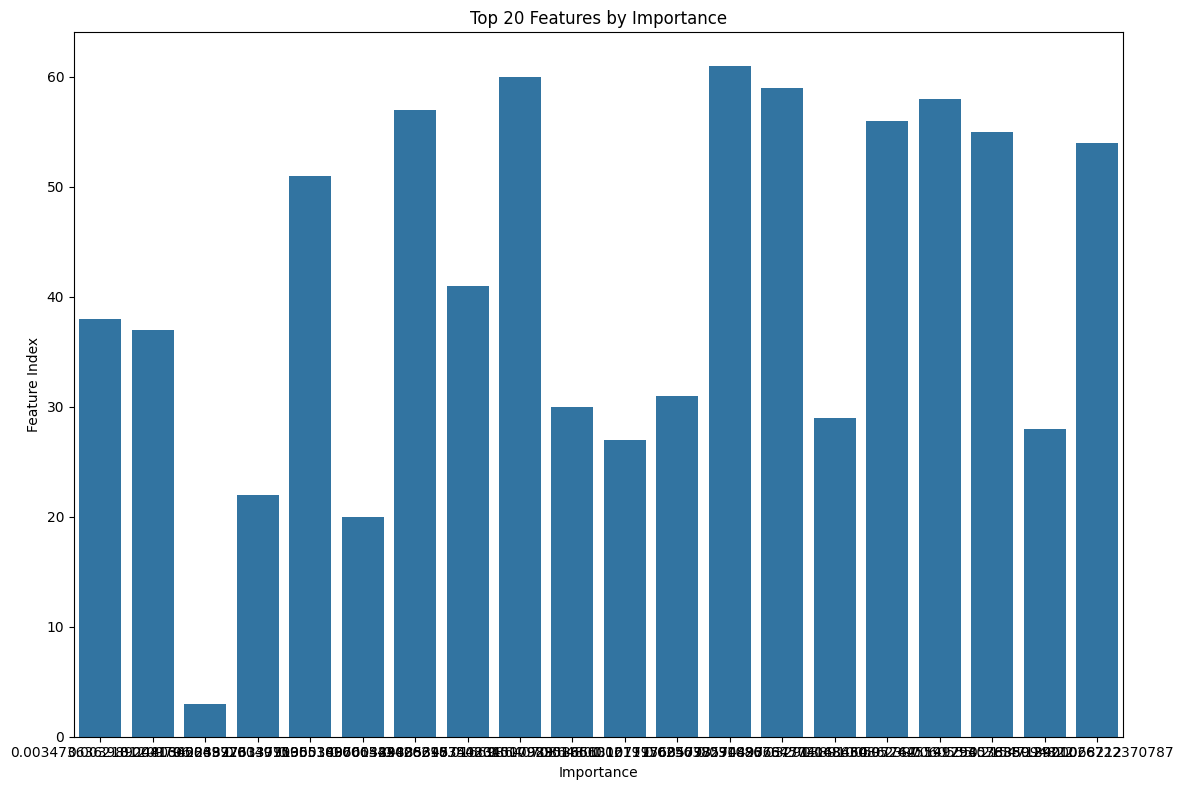

In [ ]:
best_model_type = "random_forest"
best_feature_set = "alternative"

best_pipeline = results[f"{best_model_type}_{best_feature_set}"]["pipeline"]
best_r2 = results[f"{best_model_type}_{best_feature_set}"]["r2"]

print(f"\nbest model : {best_model_type} with {best_feature_set} features")
print(f"Model R² = {best_r2:.4f}")

if best_feature_set == 'optimized':
    X_test_best = X_test_opt
elif best_feature_set == 'alternative':
    X_test_best = X_test_alt
else:
    X_test_best = X_test_full

if best_feature_set == 'optimized':
    best_features = optimized_features_complete
elif best_feature_set == 'alternative':
    best_features = alternative_features_complete
else:
    best_features = full_features_complete

best_model_final = best_pipeline.named_steps['model']
preprocessor_final = best_pipeline.named_steps['preprocessor']

importance_df = get_feature_importance(best_model_final, preprocessor_final, best_features)
if importance_df is not None:
    print("\nTop 20 features by importance:")
    print(importance_df.head(20))

    plt.figure(figsize=(12, 8))
    if 'Feature' in importance_df.columns:
        ax = sns.barplot(x='Importance', y='Feature', data=importance_df.head(20))
    else:
        ax = sns.barplot(x='Importance', y='Feature Index', data=importance_df.head(20))
    plt.title('Top 20 Features by Importance')
    plt.tight_layout()
    plt.show()

# new deployment pipeline for more reliable predictions


In [ ]:

from sklearn.compose import make_column_transformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestRegressor

if best_feature_set == 'alternative':
    cat_cols = [col for col in alternative_features_complete if col in categorical_features]
    num_cols = [col for col in alternative_features_complete if col not in categorical_features]

    X_train_fixed = X_train_alt
    y_train_fixed = y_train

    print(f"Training new model with {len(cat_cols)} categorical features and {len(num_cols)} numeric features")
    print(f"Categorical features: {cat_cols}")
    print(f"Numeric features: {num_cols}")

    preprocessor = make_column_transformer(
        (OneHotEncoder(handle_unknown='ignore'), cat_cols),
        (make_pipeline(SimpleImputer(strategy='median'), StandardScaler()), num_cols)
    )

    deployment_pipeline = make_pipeline(
        preprocessor,
        RandomForestRegressor(n_estimators=100, n_jobs=-1, random_state=42)
    )

    print("\nTraining deployment pipeline...")
    deployment_pipeline.fit(X_train_fixed, y_train_fixed)

    with open('/content/drive/MyDrive/geocoding_backup/hdb_deployment_pipeline.pkl', 'wb') as f:
        pickle.dump(deployment_pipeline, f)

    feature_lists = {
        'categorical_features': cat_cols,
        'numeric_features': num_cols,
        'all_features': cat_cols + num_cols
    }

    with open('/content/drive/MyDrive/geocoding_backup/hdb_feature_lists.pkl', 'wb') as f:
        pickle.dump(feature_lists, f)

    print("\nDeployment pipeline saved as 'hdb_deployment_pipeline.pkl'")
    print("Feature lists saved as 'hdb_feature_lists.pkl'")

    try:
        test_sample = X_train_fixed.iloc[10:11].copy()

        prediction = deployment_pipeline.predict(test_sample)

        idx = test_sample.index[0]
        actual = y_train_fixed.loc[idx]

        print("\nDeployment pipeline test:")
        print(f"Predicted price: ${prediction[0]:,.2f}")
        print(f"Actual price: ${actual:,.2f}")
        print(f"Difference: ${abs(prediction[0] - actual):,.2f} ({abs(prediction[0] - actual) / actual * 100:.2f}%)")
        print("\nDeployment pipeline test successful!")

    except Exception as e:
        print(f"\nError in deployment pipeline test: {str(e)}")

Training new model with 3 categorical features and 5 numeric features
Categorical features: ['town', 'flat_type', 'flat_model']
Numeric features: ['area_cbd_interaction_scaled', 'remaining_lease_at_transaction', 'location_score', 'area_premium_for_flattype', 'floor_mrt_premium_scaled']

Training deployment pipeline...

Deployment pipeline saved as 'hdb_deployment_pipeline.pkl'
Feature lists saved as 'hdb_feature_lists.pkl'

Deployment pipeline test:
Predicted price: $478,150.00
Actual price: $475,000.00
Difference: $3,150.00 (0.66%)

Deployment pipeline test successful!


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#Testing

In [1]:

import pandas as pd
import pickle
import numpy as np

with open('/content/drive/MyDrive/geocoding_backup/hdb_deployment_pipeline.pkl', 'rb') as f:
    pipeline = pickle.load(f)

with open('/content/drive/MyDrive/geocoding_backup/hdb_feature_lists.pkl', 'rb') as f:
    feature_lists = pickle.load(f)

categorical_features = feature_lists['categorical_features']
numeric_features = feature_lists['numeric_features']
all_features = feature_lists['all_features']

print(f"Required categorical features: {categorical_features}")
print(f"Required numeric features: {numeric_features}")

def predict_hdb_price(property_data):
    """
    Predict HDB property price using a dictionary of property features

    Parameters:
    -----------
    property_data : dict
        Dictionary containing property features

    Returns:
    --------
    float
        Predicted price
    """
    df = pd.DataFrame([property_data])

    missing_features = [feat for feat in all_features if feat not in df.columns]
    if missing_features:
        print(f"Warning: Missing required features: {missing_features}")
        return None

    df_features = df[all_features]

    try:
        prediction = pipeline.predict(df_features)
        return prediction[0]
    except Exception as e:
        print(f"Error making prediction: {str(e)}")
        return None

test_property_1 = {

    'town': 'ANG MO KIO',
    'flat_type': '4 ROOM',
    'flat_model': 'IMPROVED',


    'area_cbd_interaction_scaled': 0.45,
    'remaining_lease_at_transaction': 70,
    'location_score': 0.6,
    'floor_mrt_premium_scaled': 0.7,
    'area_premium_for_flattype': 0.2
}

test_property_2 = {

    'town': 'TAMPINES',
    'flat_type': '5 ROOM',
    'flat_model': 'STANDARD',


    'area_cbd_interaction_scaled': 0.3,
    'remaining_lease_at_transaction': 85,
    'location_score': 0.55,
    'floor_mrt_premium_scaled': 0.8,
    'area_premium_for_flattype': 0.4
}

price_1 = predict_hdb_price(test_property_1)
price_2 = predict_hdb_price(test_property_2)

print(f"\nPredicted price for 4-room flat in Ang Mo Kio: ${price_1:,.2f}")
print(f"Predicted price for 5-room flat in Tampines: ${price_2:,.2f}")

def create_test_property():
    """Interactive function to create a test property"""
    print("\nown property to test:")

    towns = ['ANG MO KIO', 'BEDOK', 'BISHAN', 'BUKIT MERAH', 'BUKIT BATOK',
             'CLEMENTI', 'GEYLANG', 'HOUGANG', 'JURONG EAST', 'JURONG WEST',
             'KALLANG/WHAMPOA', 'MARINE PARADE', 'PASIR RIS', 'PUNGGOL',
             'QUEENSTOWN', 'SEMBAWANG', 'SENGKANG', 'SERANGOON', 'TAMPINES',
             'TOA PAYOH', 'WOODLANDS', 'YISHUN']

    flat_types = ['1 ROOM', '2 ROOM', '3 ROOM', '4 ROOM', '5 ROOM', 'EXECUTIVE', 'MULTI-GENERATION']

    flat_models = ['IMPROVED', 'NEW GENERATION', 'STANDARD', 'APARTMENT', 'SIMPLIFIED',
                   'MODEL A', 'PREMIUM APARTMENT', 'MAISONETTE', 'TERRACE', 'DBSS', 'TYPE S1', 'TYPE S2']

    print("\nAvailable towns:")
    for i, town in enumerate(towns):
        print(f"{i+1}. {town}")

    town_idx = int(input("\nSelect town (enter number): ")) - 1
    town = towns[town_idx] if 0 <= town_idx < len(towns) else 'ANG MO KIO'

    print("\nAvailable flat types:")
    for i, flat_type in enumerate(flat_types):
        print(f"{i+1}. {flat_type}")

    flat_type_idx = int(input("\nSelect flat type (enter number): ")) - 1
    flat_type = flat_types[flat_type_idx] if 0 <= flat_type_idx < len(flat_types) else '4 ROOM'

    print("\nAvailable flat models:")
    for i, flat_model in enumerate(flat_models):
        print(f"{i+1}. {flat_model}")

    flat_model_idx = int(input("\nSelect flat model (enter number): ")) - 1
    flat_model = flat_models[flat_model_idx] if 0 <= flat_model_idx < len(flat_models) else 'IMPROVED'

    area_cbd = float(input("\nEnter area_cbd_interaction_scaled (0.1-0.9): ") or "0.5")
    remaining_lease = float(input("Enter remaining lease in years (40-99): ") or "70")
    location_score = float(input("Enter location_score (0.1-0.9): ") or "0.6")
    floor_mrt = float(input("Enter floor_mrt_premium_scaled (0.1-0.9): ") or "0.7")
    area_premium = float(input("Enter area_premium_for_flattype (-0.5-1.0): ") or "0.2")

    property_data = {
        'town': town,
        'flat_type': flat_type,
        'flat_model': flat_model,
        'area_cbd_interaction_scaled': area_cbd,
        'remaining_lease_at_transaction': remaining_lease,
        'location_score': location_score,
        'floor_mrt_premium_scaled': floor_mrt,
        'area_premium_for_flattype': area_premium
    }

    return property_data

custom_property = create_test_property()
custom_price = predict_hdb_price(custom_property)
print(f"\nPredicted price for custom property: ${custom_price:,.2f}")

def test_batch():
    """Test the model with a batch of properties"""
    batch_properties = []

    base_property = test_property_1.copy()
    batch_properties.append(base_property)

    property_high_floor = base_property.copy()
    property_high_floor['floor_mrt_premium_scaled'] = 0.9
    batch_properties.append(property_high_floor)

    property_old = base_property.copy()
    property_old['remaining_lease_at_transaction'] = 50
    batch_properties.append(property_old)

    property_good_loc = base_property.copy()
    property_good_loc['location_score'] = 0.8
    batch_properties.append(property_good_loc)

    property_large = base_property.copy()
    property_large['area_premium_for_flattype'] = 0.5
    batch_properties.append(property_large)

    df_batch = pd.DataFrame(batch_properties)

    predictions = pipeline.predict(df_batch[all_features])

    print("\nBatch Testing Results:")
    print("-" * 50)
    print(f"Base 4-room in Ang Mo Kio: ${predictions[0]:,.2f}")
    print(f"Same + Higher Floor: ${predictions[1]:,.2f} (Difference: ${predictions[1]-predictions[0]:,.2f})")
    print(f"Same + Older Lease (50y): ${predictions[2]:,.2f} (Difference: ${predictions[2]-predictions[0]:,.2f})")
    print(f"Same + Better Location: ${predictions[3]:,.2f} (Difference: ${predictions[3]-predictions[0]:,.2f})")
    print(f"Same + Larger Size: ${predictions[4]:,.2f} (Difference: ${predictions[4]-predictions[0]:,.2f})")

test_batch()

FileNotFoundError: [Errno 2] No such file or directory: '/content/drive/MyDrive/geocoding_backup/hdb_deployment_pipeline.pkl'

In [ ]:

import pandas as pd
import pickle
import numpy as np
import re

with open('/content/drive/MyDrive/geocoding_backup/hdb_deployment_pipeline.pkl', 'rb') as f:
    pipeline = pickle.load(f)

with open('/content/drive/MyDrive/geocoding_backup/hdb_feature_lists.pkl', 'rb') as f:
    feature_lists = pickle.load(f)

categorical_features = feature_lists['categorical_features']
numeric_features = feature_lists['numeric_features']
all_features = feature_lists['all_features']

def extract_town_from_address(address):
    """Extract town from address based on known HDB towns"""

    hdb_towns = [
        'ANG MO KIO', 'BEDOK', 'BISHAN', 'BUKIT BATOK', 'BUKIT MERAH', 'BUKIT PANJANG',
        'BUKIT TIMAH', 'CENTRAL AREA', 'CHOA CHU KANG', 'CLEMENTI', 'GEYLANG',
        'HOUGANG', 'JURONG EAST', 'JURONG WEST', 'KALLANG/WHAMPOA', 'MARINE PARADE',
        'PASIR RIS', 'PUNGGOL', 'QUEENSTOWN', 'SEMBAWANG', 'SENGKANG', 'SERANGOON',
        'TAMPINES', 'TOA PAYOH', 'WOODLANDS', 'YISHUN', 'CANBERRA'
    ]

    address_upper = address.upper()
    for town in hdb_towns:
        if town in address_upper:
            return town

    if 'CANBERRA' in address_upper:
        return 'SEMBAWANG'

    return None

def get_region_numeric(town):
    """Convert town to region_numeric (0=CCR, 1=RCR, 2=OCR)"""
    ccr_towns = ['DOWNTOWN CORE', 'MARINA SOUTH', 'MARINA EAST', 'SOUTHERN ISLANDS',
                'MUSEUM', 'RIVER VALLEY', 'ORCHARD', 'NEWTON']

    rcr_towns = ['BISHAN', 'TOA PAYOH', 'GEYLANG', 'KALLANG/WHAMPOA', 'MARINE PARADE',
                'QUEENSTOWN', 'BUKIT MERAH', 'CENTRAL AREA', 'BUKIT TIMAH', 'NOVENA']

    if town in ccr_towns:
        return 0
    elif town in rcr_towns:
        return 1
    else:
        return 2  # OCR

def calculate_derived_features(town, floor_level, flat_type, area_sqm):
    """Calculate derived features from basic property information"""

    region_numeric = get_region_numeric(town)

    old_towns = ['ANG MO KIO', 'BEDOK', 'CLEMENTI', 'GEYLANG', 'QUEENSTOWN', 'TOA PAYOH']
    newer_towns = ['PUNGGOL', 'SENGKANG', 'CANBERRA', 'SEMBAWANG']

    if town in newer_towns:
        remaining_lease = 90
    elif town in old_towns:
        remaining_lease = 60
    else:
        remaining_lease = 70

    nearest_mrt_distance = 1.0

    town_central_blocks = {
        'ANG MO KIO': range(1, 200),
        'BEDOK': range(1, 200),
        'TAMPINES': range(1, 300),
        'SEMBAWANG': range(300, 500),
    }

    block_match = re.search(r'BLK\s+(\d+)', town, re.IGNORECASE)
    if not block_match:
        block_match = re.search(r'BLOCK\s+(\d+)', town, re.IGNORECASE)
    if not block_match:
        block_match = re.search(r'(\d+)', town)

    if block_match:
        block_num = int(block_match.group(1))
        for town_name, block_range in town_central_blocks.items():
            if town_name in town.upper() and block_num in block_range:
                nearest_mrt_distance = 0.6  # Closer to MRT
                break

    is_high_floor = int(floor_level) > 10
    is_near_mrt = nearest_mrt_distance < 0.8
    high_floor_mrt_proximity = 1 if (is_high_floor and is_near_mrt) else 0

    floor_mrt_premium = int(floor_level) * (1 / (nearest_mrt_distance + 0.1))
    floor_mrt_premium_scaled = min(floor_mrt_premium / 35, 0.9)

    if region_numeric == 0:  # CCR
        distance_to_cbd = 2
    elif region_numeric == 1:  # RCR
        distance_to_cbd = 8
    else:  # OCR
        distance_to_cbd = 15

    area_cbd_interaction = area_sqm * (1 / (distance_to_cbd + 1))
    area_cbd_interaction_scaled = min(area_cbd_interaction / 60, 0.9)

    region_lease_interaction = region_numeric * remaining_lease

    base_location_score = 0.6

    if region_numeric == 0:
        base_location_score += 0.2
    elif region_numeric == 1:
        base_location_score += 0.1

    if nearest_mrt_distance < 0.5:
        base_location_score += 0.1
    elif nearest_mrt_distance > 1.5:
        base_location_score -= 0.1

    popular_towns = ['BISHAN', 'QUEENSTOWN', 'MARINE PARADE', 'CLEMENTI']
    if town in popular_towns:
        base_location_score += 0.05

    location_score = min(max(base_location_score, 0.1), 0.9)  # Keep within 0.1-0.9 range

    avg_sizes = {
        '1 ROOM': 35,
        '2 ROOM': 45,
        '3 ROOM': 65,
        '4 ROOM': 90,
        '5 ROOM': 110,
        'EXECUTIVE': 130,
        'MULTI-GENERATION': 150
    }

    avg_size = avg_sizes.get(flat_type, 90)
    size_diff = area_sqm - avg_size
    area_premium_for_flattype = size_diff / avg_size  # Positive if larger than average

    area_premium_for_flattype = min(max(area_premium_for_flattype, -0.3), 0.7)

    if flat_type in ['4 ROOM', '5 ROOM'] and town in newer_towns:
        flat_model = 'PREMIUM APARTMENT'
    elif flat_type == 'EXECUTIVE':
        flat_model = 'MAISONETTE'
    elif town in old_towns:
        flat_model = 'STANDARD'
    else:
        flat_model = 'IMPROVED'

    features = {
        'town': town,
        'flat_type': flat_type,
        'flat_model': flat_model,
        'area_cbd_interaction_scaled': area_cbd_interaction_scaled,
        'remaining_lease_at_transaction': remaining_lease,
        'location_score': location_score,
        'floor_mrt_premium_scaled': floor_mrt_premium_scaled,
        'area_premium_for_flattype': area_premium_for_flattype,
        'high_floor_mrt_proximity': high_floor_mrt_proximity,
        'region_numeric': region_numeric
    }

    return features

def estimate_hdb_price(address, floor_level, unit_number, flat_type, area_sqm):
    """
    Estimate HDB price using address and basic property details

    Parameters:
    -----------
    address : str
        Full address or block and street
    floor_level : int
        Floor level of the unit
    unit_number : str
        Unit number (not used in prediction but helps identify the unit)
    flat_type : str
        Type of flat (e.g., "4 ROOM", "5 ROOM")
    area_sqm : float
        Floor area in square meters

    Returns:
    --------
    float
        Estimated property price
    """
    town = extract_town_from_address(address)

    if not town:
        print(f"Warning: Could not determine town from address '{address}'")
        print("Please specify town directly.")
        town = input("Enter town name: ").upper()

    features = calculate_derived_features(town, floor_level, flat_type, area_sqm)

    df = pd.DataFrame([features])

    required_features = [f for f in all_features if f in df.columns]
    df_features = df[required_features]

    missing_features = [f for f in all_features if f not in df_features.columns]
    if missing_features:
        print(f"Warning: Missing required features: {missing_features}")
        return None

    try:
        prediction = pipeline.predict(df_features)

        # Print the derived features for reference
        print("\nDerived features used for prediction:")
        for key, value in features.items():
            print(f"  {key}: {value}")

        return prediction[0]
    except Exception as e:
        print(f"Error making prediction: {str(e)}")
        return None

address = "BLK 303 CANBERRA"
floor_level = 14
unit_number = 35
flat_type = "4 ROOM"
area_sqm = 100

estimated_price = estimate_hdb_price(address, floor_level, unit_number, flat_type, area_sqm)

if estimated_price:
    print(f"\nEstimated price for {flat_type} at {address}, #{floor_level}-{unit_number} ({area_sqm} sqm):")
    print(f"${estimated_price:,.2f}")

def interactive_price_check():
    """Interactive function to check HDB prices by address"""
    print("\n=== HDB Property Valuation Tool ===")

    address = input("Enter block and street/area (e.g., 'BLK 303 CANBERRA'): ")
    floor_level = int(input("Enter floor level (e.g., 14): "))
    unit_number = input("Enter unit number (e.g., 35): ")

    print("\nSelect flat type:")
    flat_types = ['1 ROOM', '2 ROOM', '3 ROOM', '4 ROOM', '5 ROOM', 'EXECUTIVE', 'MULTI-GENERATION']
    for i, ft in enumerate(flat_types):
        print(f"{i+1}. {ft}")

    flat_type_idx = int(input("Enter choice (1-7): ")) - 1
    flat_type = flat_types[flat_type_idx] if 0 <= flat_type_idx < len(flat_types) else '4 ROOM'

    area_sqm = float(input("Enter floor area in sqm (e.g., 100): "))

    estimated_price = estimate_hdb_price(address, floor_level, unit_number, flat_type, area_sqm)

    if estimated_price:
        print(f"\nEstimated price for {flat_type} at {address}, #{floor_level}-{unit_number} ({area_sqm} sqm):")
        print(f"${estimated_price:,.2f}")

interactive_price_check()


Derived features used for prediction:
  town: CANBERRA
  flat_type: 4 ROOM
  flat_model: PREMIUM APARTMENT
  area_cbd_interaction_scaled: 0.10416666666666667
  remaining_lease_at_transaction: 90
  location_score: 0.6
  floor_mrt_premium_scaled: 0.3636363636363636
  area_premium_for_flattype: 0.1111111111111111
  high_floor_mrt_proximity: 0
  region_numeric: 2

Estimated price for 4 ROOM at BLK 303 CANBERRA, #14-35 (100 sqm):
$763,925.78
